In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr

# Cấu hình giao diện biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [7]:
# 1. Load dữ liệu (File csv đã gom 5 phút của bạn)
# Đảm bảo file này nằm cùng thư mục
df = pd.read_csv('train_per_1m.csv', parse_dates=['ts'], index_col='ts')

# Gom nhóm về 5 phút (nếu đang là file 1 phút)
# Chúng ta cần status code cho phần sau, nên aggregate kỹ
agg_rules = {
    'requests': 'sum', 'bytes': 'sum', 
    'status_200': 'sum', 'status_500': 'sum'
}
# Fix lỗi tên cột nếu file csv dùng 'hits' thay vì 'requests'
if 'hits' in df.columns:
    df.rename(columns={'hits': 'requests'}, inplace=True)

# Tự động thêm status khác nếu có
for c in df.columns:
    if 'status_' in c and c not in agg_rules: agg_rules[c] = 'sum'

df_5m = df.resample('5min').agg(agg_rules).fillna(0)

# 2. Chia Train/Test (Đúng mốc 22/08 của đề bài)
split_date = pd.to_datetime("1995-08-22 23:59:59-04:00")
eda_train = df_5m[df_5m.index <= split_date].copy()
eda_test = df_5m[df_5m.index > split_date].copy()

print(f"EDA Train Range: {eda_train.index.min()} -> {eda_train.index.max()}")
print(f"Shape: {eda_train.shape}")

EDA Train Range: 1995-07-01 00:00:00-04:00 -> 1995-08-22 23:55:00-04:00
Shape: (15264, 6)


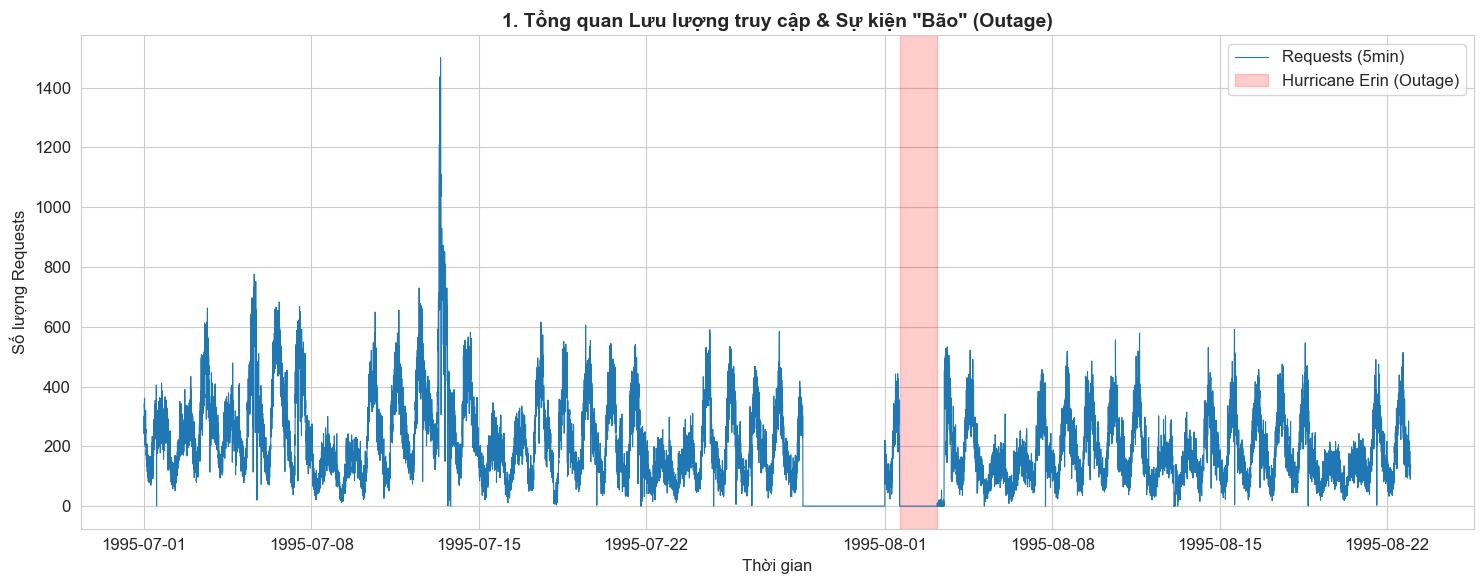

Insight: Dữ liệu bị gián đoạn từ 01/08 đến 03/08 do bão. Đây là nhiễu hệ thống, cần loại bỏ khi train model.


In [8]:
plt.figure(figsize=(15, 6))

# Vẽ đường Traffic
plt.plot(eda_train.index, eda_train['requests'], color='#1f77b4', linewidth=0.8, label='Requests (5min)')

# Tô màu vùng bão (Hurricane Erin)
hurricane_start = pd.to_datetime("1995-08-01 14:52:01-04:00")
hurricane_end = pd.to_datetime("1995-08-03 04:36:13-04:00")
plt.axvspan(hurricane_start, hurricane_end, color='red', alpha=0.2, label='Hurricane Erin (Outage)')

plt.title('1. Tổng quan Lưu lượng truy cập & Sự kiện "Bão" (Outage)', fontsize=14, fontweight='bold')
plt.ylabel('Số lượng Requests')
plt.xlabel('Thời gian')
plt.legend()
plt.tight_layout()
plt.savefig('eda_overview_hurricane.png') # Lưu ảnh để nộp báo cáo
plt.show()

print("Insight: Dữ liệu bị gián đoạn từ 01/08 đến 03/08 do bão. Đây là nhiễu hệ thống, cần loại bỏ khi train model.")

C:\Users\ductd\AppData\Local\Temp\ipykernel_4996\2868253214.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='requests', data=eda_train, ax=axes[0], palette='viridis', showfliers=False)


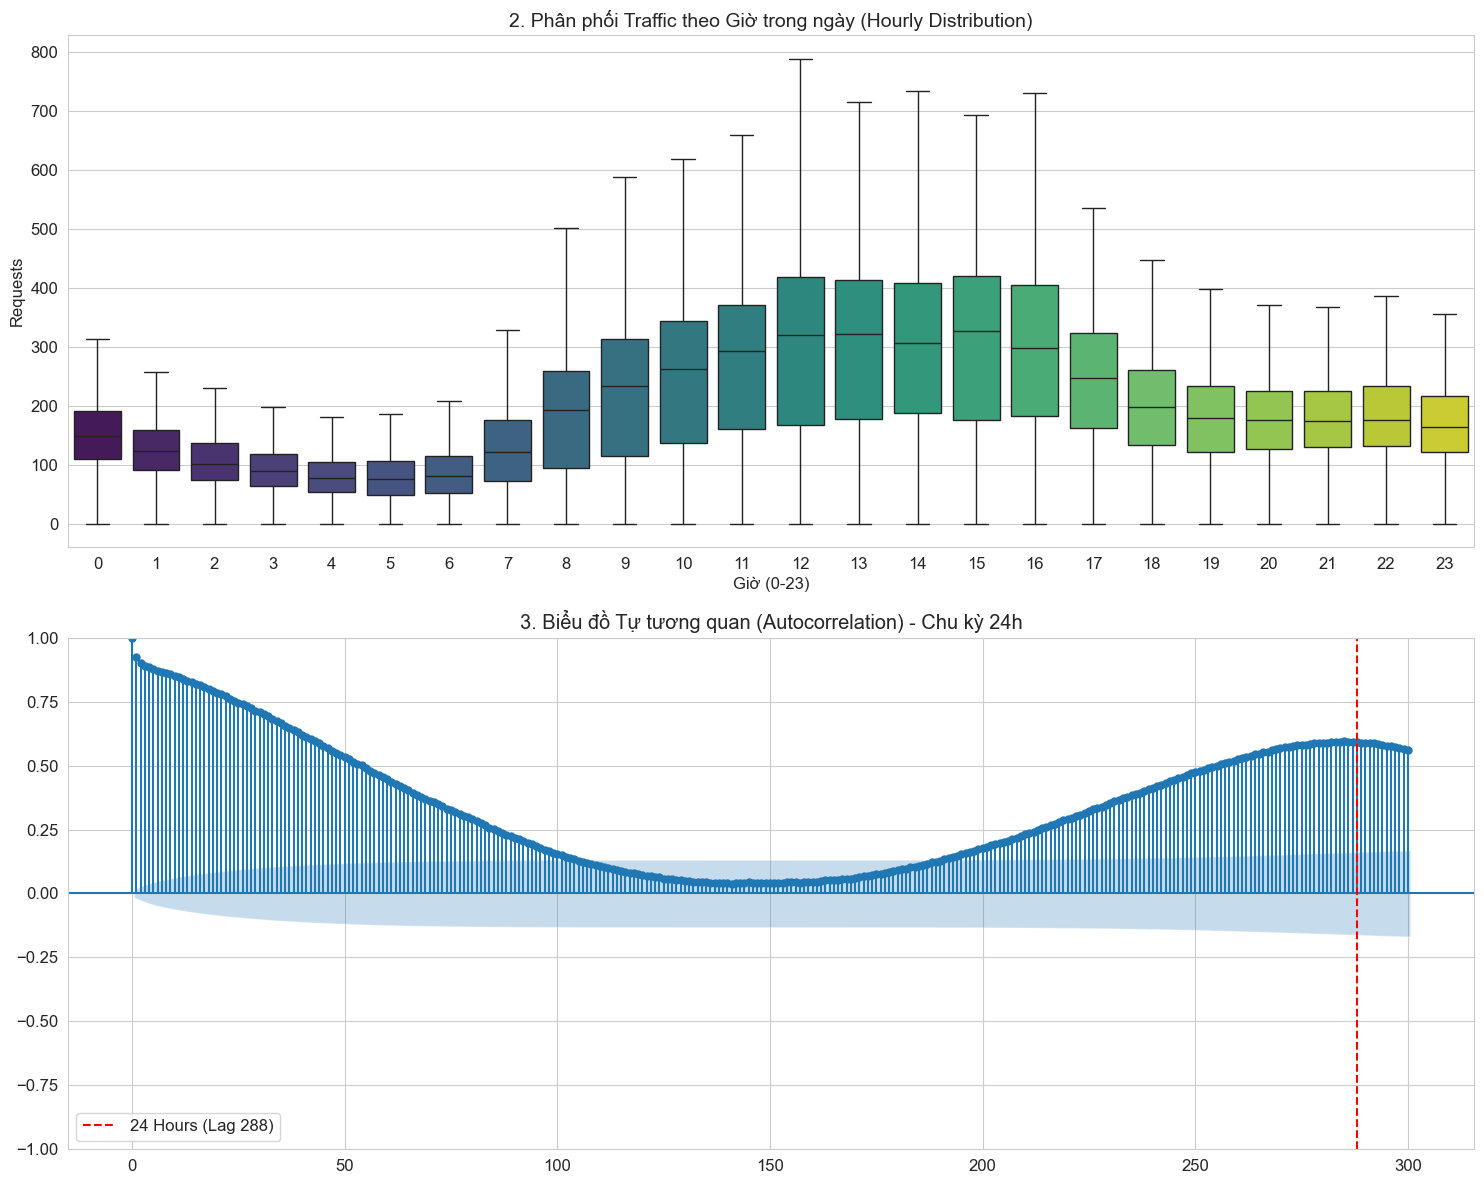

Insight: Traffic có tính chu kỳ ngày rất rõ (cao điểm trưa/chiều, thấp điểm đêm). Lag 288 (24h) có tương quan mạnh nhất.


In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 4.1. Boxplot theo giờ (Hourly Seasonality)
eda_train['hour'] = eda_train.index.hour
sns.boxplot(x='hour', y='requests', data=eda_train, ax=axes[0], palette='viridis', showfliers=False)
axes[0].set_title('2. Phân phối Traffic theo Giờ trong ngày (Hourly Distribution)', fontsize=14)
axes[0].set_xlabel('Giờ (0-23)')
axes[0].set_ylabel('Requests')

# 4.2. Autocorrelation (ACF)
# Lag 288 = 24 giờ * (60/5)
plot_acf(eda_train['requests'], lags=300, ax=axes[1], title='3. Biểu đồ Tự tương quan (Autocorrelation) - Chu kỳ 24h')
axes[1].axvline(x=288, color='red', linestyle='--', label='24 Hours (Lag 288)')
axes[1].legend()

plt.tight_layout()
plt.savefig('eda_seasonality.png')
plt.show()

print("Insight: Traffic có tính chu kỳ ngày rất rõ (cao điểm trưa/chiều, thấp điểm đêm). Lag 288 (24h) có tương quan mạnh nhất.")

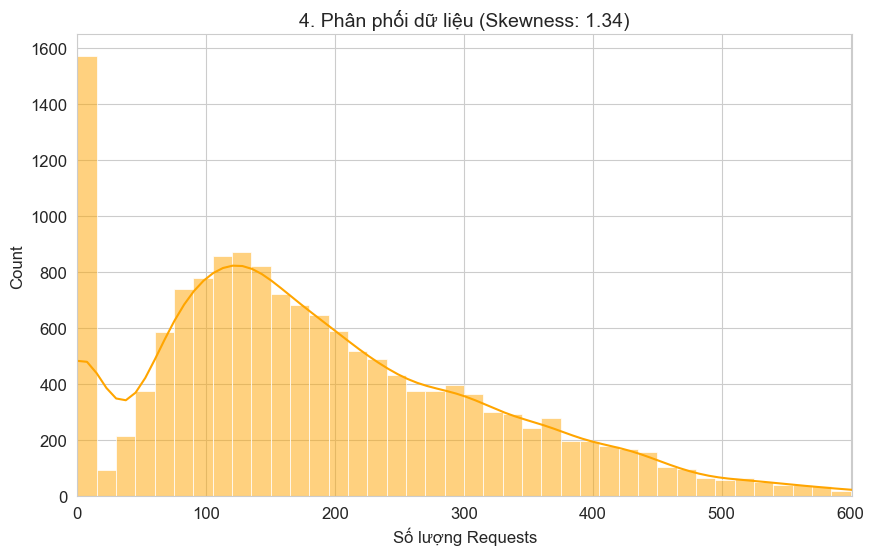

Insight: Dữ liệu bị lệch dương nặng (Skew = 1.34). Cần áp dụng Log-Transform (np.log1p) để mô hình học tốt hơn.


In [10]:
plt.figure(figsize=(10, 6))

# Vẽ histogram
sns.histplot(eda_train['requests'], kde=True, bins=100, color='orange')

skew_val = eda_train['requests'].skew()
plt.title(f'4. Phân phối dữ liệu (Skewness: {skew_val:.2f})', fontsize=14)
plt.xlabel('Số lượng Requests')
plt.xlim(0, eda_train['requests'].quantile(0.99)) # Zoom vào vùng chính

plt.savefig('eda_distribution.png')
plt.show()

print(f"Insight: Dữ liệu bị lệch dương nặng (Skew = {skew_val:.2f}). Cần áp dụng Log-Transform (np.log1p) để mô hình học tốt hơn.")

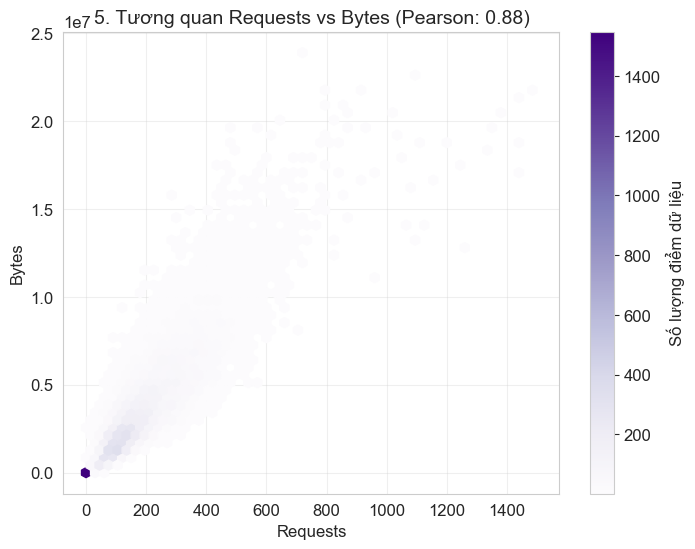

Insight: Tương quan rất mạnh (0.88). Có thể dùng kết quả dự báo Requests làm đầu vào (feature) để dự báo Bytes.


In [11]:
# Tính hệ số tương quan
corr, _ = pearsonr(eda_train['requests'], eda_train['bytes'])

plt.figure(figsize=(8, 6))
# Dùng hexbin hoặc scatter với alpha thấp vì dữ liệu dày
plt.hexbin(eda_train['requests'], eda_train['bytes'], gridsize=50, cmap='Purples', mincnt=1)
plt.colorbar(label='Số lượng điểm dữ liệu')

plt.title(f'5. Tương quan Requests vs Bytes (Pearson: {corr:.2f})', fontsize=14)
plt.xlabel('Requests')
plt.ylabel('Bytes')
plt.grid(True, alpha=0.3)

plt.savefig('eda_correlation.png')
plt.show()

print("Insight: Tương quan rất mạnh (0.88). Có thể dùng kết quả dự báo Requests làm đầu vào (feature) để dự báo Bytes.")

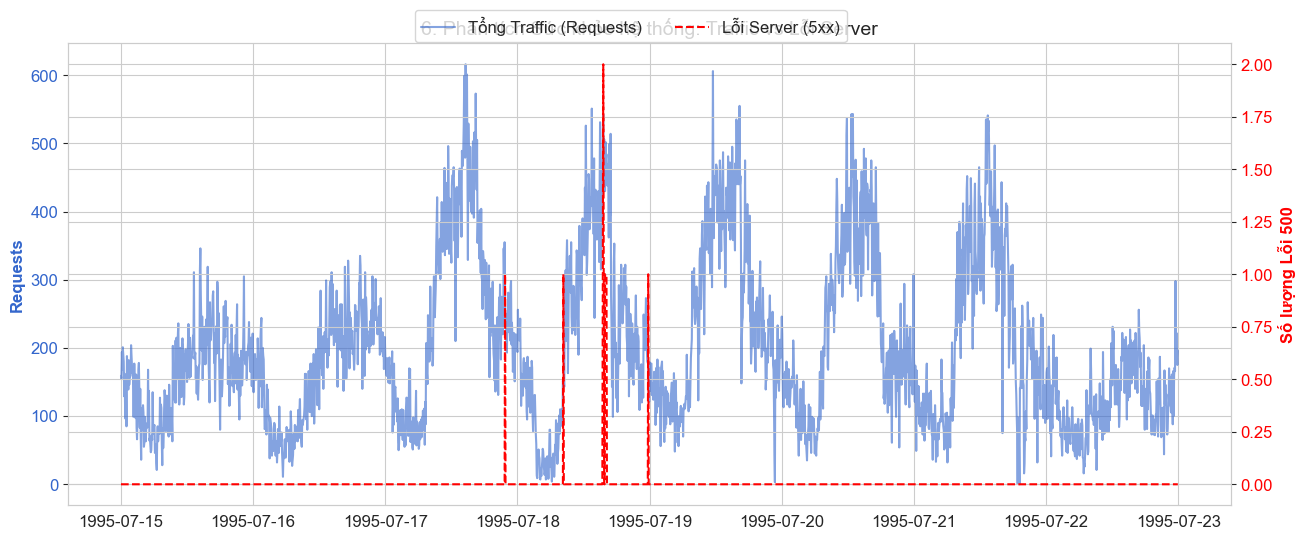

Insight: Có những thời điểm Lỗi 5xx tăng vọt độc lập với Traffic. Việc thêm Feature 'ratio_5xx' sẽ giúp Model nhận biết trạng thái bất ổn của server.


In [12]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Lọc giai đoạn thú vị (ví dụ 1 tuần giữa tháng 7) để nhìn rõ hơn
subset = eda_train['1995-07-15':'1995-07-22']

# Vẽ Request tổng (Trục trái)
ax1.plot(subset.index, subset['requests'], color='#3366CC', alpha=0.6, label='Tổng Traffic (Requests)')
ax1.set_ylabel('Requests', color='#3366CC', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#3366CC')

# Vẽ Lỗi 500 (Trục phải)
ax2 = ax1.twinx()
ax2.plot(subset.index, subset['status_500'], color='red', linewidth=1.5, linestyle='--', label='Lỗi Server (5xx)')
ax2.set_ylabel('Số lượng Lỗi 500', color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('6. Phân tích Sức khỏe hệ thống: Traffic vs Lỗi Server', fontsize=14)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, frameon=True)

plt.savefig('eda_system_health.png')
plt.show()

print("Insight: Có những thời điểm Lỗi 5xx tăng vọt độc lập với Traffic. Việc thêm Feature 'ratio_5xx' sẽ giúp Model nhận biết trạng thái bất ổn của server.")

KẾT LUẬN EDA & CHIẾN LƯỢC MÔ HÌNH:

1.Xử lý dữ liệu: Cần loại bỏ giai đoạn 01/08 - 03/08 (Bão) khỏi tập Train. Áp dụng Log-transform cho requests và bytes.

2.Feature Engineering:

    -Dùng Lag 288 (24h) và Lag 1 (5m) làm feature chính.

    -Dùng Hour of Day để bắt chu kỳ ngày.

3.Chiến lược Hybrid: Quan sát biểu đồ số 6 cho thấy cần đưa status_5xx vào mô hình để phân biệt giữa nhu cầu thật và lỗi hệ thống.

4.Chiến lược Bytes: Quan sát biểu đồ số 5 xác nhận việc dùng mô hình Requests để hỗ trợ dự báo Bytes là khả thi.